In [1]:
import os
from os import path as osp
import torch
import matplotlib.pyplot as plt
from PIL import Image
import load_alov
import sys
sys.path.append("..")
import numpy as np
import detect
from darknet import Darknet
from utils import *

In [2]:
data = load_alov.load_alov()

In [3]:
data['05-Shape_video00009']

(['/data/alov/05-Shape/05-Shape_video00009/00000001.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000002.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000003.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000004.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000005.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000006.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000007.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000008.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000009.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000010.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000011.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000012.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000013.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000014.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000015.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000016.jpg',
  '/data/alov/05-Shape/05-Shape_video00009/00000017.jpg',
  '/data/alov/

In [4]:
cfgfile = "../cfg/yolo.cfg"
weightfile = "../yolo.weights"
namesfile = '../data/coco.names'
use_cuda=True
m = Darknet(cfgfile).cuda()
m.print_network()
m.load_weights(weightfile)

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 max          2 x 2 / 2   416 x 416 x  32   ->   208 x 208 x  32
    2 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    3 max          2 x 2 / 2   208 x 208 x  64   ->   104 x 104 x  64
    4 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    5 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    6 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    7 max          2 x 2 / 2   104 x 104 x 128   ->    52 x  52 x 128
    8 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
    9 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   10 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   11 max          2 x 2 / 2    52 x  52 x 256   ->    26 x  26 x 256
   12 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
   13 conv    256  1 x 

In [5]:
def plot_single(im, box=None, line="r-", resize=True):
    plt.imshow(im)

#     if pr_path is not None:
#         with open(pr_path, 'r') as f:
#             l = f.read().split("\n")[pr_idx]
#             if l == "":
#                 return
#             pr_bb = [float(x) for x in l.split(',')]

#         if (force_square):
#             X, Y = pr_bb[::2], pr_bb[1::2]
#             pr_bb = [min(X), min(Y), max(X),  max(Y)]
#             plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
#                      [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)
#         elif (len(pr_bb) == 8):
#             plt.plot(pr_bb[::2] + [pr_bb[0]],
#                      pr_bb[1::2] + [pr_bb[1]], 'r-', lw=2)
#         else:
#             plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
#                      [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)

    if box is not None and resize:  
        width, height = im.width, im.height
        x1 = (box[0] - box[2] / 2.0) * width
        y1 = (box[1] - box[3] / 2.0) * height
        x2 = (box[0] + box[2] / 2.0) * width
        y2 = (box[1] + box[3] / 2.0) * height
    else:
        if len(box) > 4:
            box = force_square(box)
        x1, y1, x2, y2 = box
        
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], line, lw=2)

    return [x1, x2, y1, y2]    

In [40]:
def iou(box_a, box_b):
    # IoU between two boxes
    box_a = box_a[0:4] if len(box_a) != 4 else box_a
    box_b = box_b[0:4] if len(box_b) != 4 else box_b

    x_a = np.max((box_a[0], box_b[0]))
    y_a = np.max((box_a[1], box_b[1]))
    x_b = np.min((box_a[2], box_b[2]))
    y_b = np.min((box_a[3], box_b[3]))

    inter_area = np.max((0., x_b - x_a + 1)) * np.max((0., y_b - y_a + 1))
    box_a_area = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    box_b_area = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)
    a = (box_a_area + box_b_area - inter_area)
    res = inter_area / a
    return res

In [80]:
def choose_best_by_emb(prev, candidates, thr=.3):
    best_dist = thr
    best_track_idx = 0
    prev_emb = np.array(prev[7:-2])
    
    for n, candidate in enumerate(candidates):
        cand_emb = np.array(candidate[7:-2])
        emb_dist = torch.mean((cand_emb[0] - prev_emb[0]) ** 2)
        if emb_dist < best_dist:
            best_dist = emb_dist
            best_track_idx = n
    
    if best_dist < thr:
        return candidates[best_track_idx]
    return prev

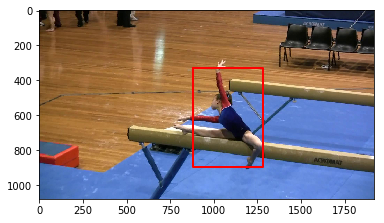

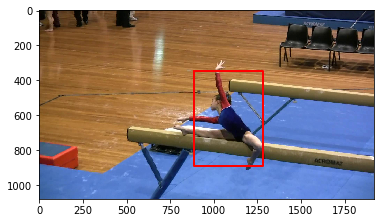

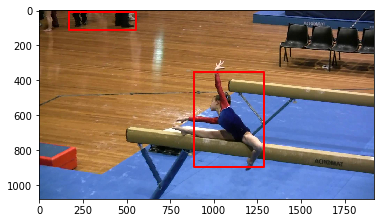

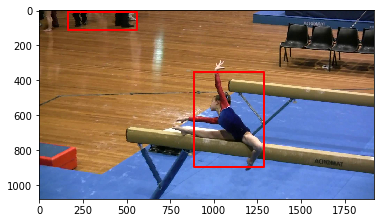

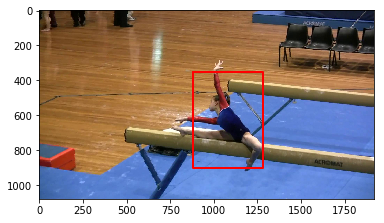

KeyboardInterrupt: 

In [17]:
for img in data['05-Shape_video00009'][0]:
    image = Image.open(img).convert('RGB')
    sized = image.resize((m.width, m.height))
    boxes = do_detect(m, sized, 0.5, 0.4, use_cuda)
    for box in boxes:
        bbox = [float(x) for x in box[:4]]
        plot_single(image, bbox)
    plt.show()
    plt.close()

In [37]:
def best_iou(candidates, gt, width=None, height=None):
    best_iou = 0
    best_index = 0
    _iou = 0
    for i, candidate in enumerate(candidates):
        c = candidate
        if len(c) > 4:
            c = c[0:4]
        if width is not None:
            x1 = (c[0] - c[2] / 2.0) * width
            y1 = (c[1] - c[3] / 2.0) * height
            x2 = (c[0] + c[2] / 2.0) * width
            y2 = (c[1] + c[3] / 2.0) * height
            c = np.array([x1, y1, x2, y2])
        _iou = iou(c, gt)
        if _iou > best_iou:
            best_iou = _iou
            best_index = i
    return candidates[best_index] if _iou > 0 else None

In [10]:
def file2tensor(file):
    with open(file, 'r') as f:
        lines = torch.tensor([[float(y) for y in x.split()] for x in f.readlines()])
        return lines

In [11]:
def read_gt(file, idx=None):
    tensor = file2tensor(file)
    if idx is not None:
        return tensor[idx]
    else:
        return tensor
    

In [12]:
def tensor_to_bb(gt, gt_idx):
    gt_bb = gt[gt[:, 0] <= gt_idx + 1][-1]
    index, gt_bb = gt_bb[0].tolist(), gt_bb[1:].tolist()
    return index, gt_bb

In [20]:
def force_square(m):
    return [min(m[::2]), min(m[1::2]), max(m[::2]), max(m[1::2])]

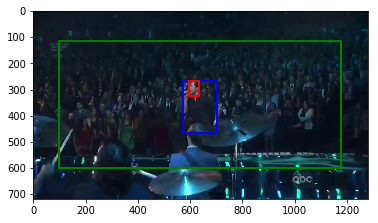

candidate
[tensor(0.4885), tensor(0.4179), tensor(0.8727), tensor(0.8017), tensor(0.5885), tensor(0.9941), tensor(0), tensor([-0.0686, -0.0178, -0.0171,  ...,  1.7598, -0.1866, -0.2243],
       device='cuda:0', grad_fn=<SelectBackward>), 5, 6]
candidate
cand_emb
[tensor([-0.0686, -0.0178, -0.0171,  ...,  1.7598, -0.1866, -0.2243],
       device='cuda:0', grad_fn=<SelectBackward>)]
cand_emb
torch.Size([1024])


AttributeError: 'torch.dtype' object has no attribute 'type'

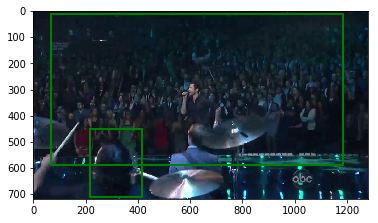

In [64]:
hero = None
for img in data['08-Clutter_video00002'][0]:
    image = Image.open(img).convert('RGB')
    sized = image.resize((m.width, m.height))
    boxes = do_detect(m, sized, 0.5, 0.4, use_cuda)
    for box in boxes:
        plot_single(image, box, "g-")
    if len(boxes) == 0:
        plot_single(image, hero)
        plt.show()
        plt.close()
        continue
    if hero is None:
        gt = read_gt(data['08-Clutter_video00002'][1])
        true_box = tensor_to_bb(gt, 0)[1]
        hero = best_iou(boxes, force_square(true_box), image.width, image.height)
    else:
        hero = choose_best_by_emb(hero, boxes)
    plot_single(image, hero[0:4], 'b-', resize=True)
    plot_single(image, true_box, 'r-', resize=False)

    plt.show()
    plt.close()

[tensor(0.4999), tensor(0.5089), tensor(0.7151), tensor(0.9254), tensor(0.8490), tensor(0.9988), tensor(0), tensor([-0.0110, -0.0817, -0.0001,  ...,  0.4952, -0.3154,  0.7351],
       device='cuda:0', grad_fn=<SelectBackward>), 6, 6]
[tensor(0.1277), tensor(0.1989), tensor(0.2246), tensor(0.3749), tensor(0.6577), tensor(0.9923), tensor(58), tensor([-0.1579,  0.2341, -0.2841,  ...,  0.3352,  0.0891, -0.1341],
       device='cuda:0', grad_fn=<SelectBackward>), 2, 1]
[tensor(0.1317), tensor(0.5616), tensor(0.0757), tensor(0.2447), tensor(0.6439), tensor(0.8548), tensor(41), tensor([-0.1234, -0.0012, -0.1895,  ...,  1.8019, -0.1520,  1.5982],
       device='cuda:0', grad_fn=<SelectBackward>), 7, 1]
[tensor(0.3974), tensor(0.3547), tensor(0.1242), tensor(0.2486), tensor(0.6168), tensor(0.9743), tensor(56), tensor([-0.0048, -0.0750, -0.2252,  ...,  0.0209, -0.1805, -0.1563],
       device='cuda:0', grad_fn=<SelectBackward>), 4, 5]
[tensor(0.1810), tensor(0.7363), tensor(0.3669), tensor(0.516

IndexError: index -1 is out of bounds for dimension 0 with size 0

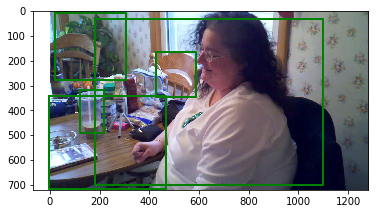

In [86]:
hero = None
for img in data['08-Clutter_video00003'][0]:
    image = Image.open(img).convert('RGB')
    sized = image.resize((m.width, m.height))
    boxes = do_detect(m, sized, 0.5, 0.4, use_cuda)
    for box in boxes:
        print(box)
        plot_single(image, box, "g-")
    if len(boxes) == 0:
        plot_single(image, hero)
        plt.show()
        plt.close()
        continue
    if hero is None:
        gt = read_gt(data['08-Clutter_video00003'][1])
        print(gt)
        true_box = tensor_to_bb(gt, 0)[1]
        hero = best_iou(boxes, force_square(true_box), image.width, image.height)
    else:
        hero = choose_best_by_emb(hero, boxes)
    plot_single(image, hero[0:4], 'b-', resize=True)
    plot_single(image, true_box, 'r-', resize=False)

    plt.show()
    plt.close()